# 02 — Custom Model Evaluation (Gradient Descent)

> **Objective:** To train and evaluate a manually implemented linear regression model using gradient descent, assess optimization behavior, and analyze predictive performance on engineered and standardized features.

This notebook includes:
1. [**Dataset preparation**](#dataset-preparation) — applying the feature engineering pipeline  
2. [**Standardization**](#standardization) — computing and applying scaling parameters  
3. [**Model training**](#model-training) — using iterative gradient descent with configurable hyperparameters
4. [**Predictive evaluation**](#predictive-evaluation) — computing MAE, RMSE, R²  
5. [**Convergence analysis**](#convergence-analysis) — inspecting the loss curve over iterations  
6. [**Error diagnostics**](#error-diagnostics) — analyzing predicted vs actual values and residual distributions  
7. [**Metric export**](#metric-export) — saving results for reproducibility

> **Note:** Section links (e.g., “Dataset preparation”) work in Jupyter or nbviewer, but may not render in static GitHub previews.

> **Note:** Run `python3 -m src.train` before this notebook if the model has not been trained yet.

The results provide insight into how the gradient-descent-trained model behaves in practice, and establish a baseline for comparison with optimized library methods.

---
### 🧰 Imports & Setup

Load the core dependencies required for evaluating the custom Gradient Descent model. These imports provide numerical operations, visualization utilities, and manually implemented project-specific modules for data loading, preprocessing, feature engineering, training, and evaluation.


- **sys.path.append("../")** — allows importing modules from the project’s `src/` directory  
- **NumPy (`numpy`)** — numerical operations and array computations  
- **Pandas (`pandas`)** — dataset handling and tabular operations  
- **Matplotlib / Seaborn** — visualizations and diagnostic plots  
- **Project modules (`src/...`)** — utilities for model loading, preprocessing, feature engineering, training, and performance evaluation 

In [1]:
import sys
sys.path.append("../")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.model_io import load_model
from src.preprocessing import compute_standardization_params, apply_standardization
from src.data_loader import train_test_split_data
from src.feature_engineering import apply_feature_engineering
from src.config import Config
from src.evaluation import evaluate_regression
from src.gradient_descent import LinearRegressionGD

sns.set(style="whitegrid")

### 📥 Load Dataset
Initialize the project configuration and load the raw California Housing dataset. Viewing the first few rows helps confirm that the data is structured correctly before applying feature engineering steps.

In [2]:
config = Config()

df = pd.read_csv("../data/raw/housing.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### 🧪 Apply Feature Engineering <a id="dataset-preparation"></a>

Apply the custom feature engineering pipeline to the raw dataset. This step generates additional transformed and ratio-based features designed to address skewed distributions, scale imbalances, and nonlinear relationships observed during exploratory analysis.

In [3]:
df_fe = apply_feature_engineering(df)
df_fe.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_INLAND,...,ocean_proximity_NEAR OCEAN,log_median_income,log_total_rooms,log_total_bedrooms,log_population,log_households,rooms_per_household,bedrooms_per_room,population_per_household,median_income_sq
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,False,...,False,2.232720,6.781058,4.867534,5.777652,4.844187,6.984127,0.146591,2.555556,69.308955
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,False,...,False,2.230165,8.867850,7.009409,7.784057,7.037906,6.238137,0.155797,2.109842,68.913242
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,False,...,False,2.111110,7.291656,5.252273,6.208590,5.181784,8.288136,0.129516,2.802260,52.669855
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,False,...,False,1.893579,7.150701,5.463832,6.326149,5.393628,5.817352,0.184458,2.547945,31.844578
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,False,...,False,1.578195,7.395108,5.638355,6.338594,5.560682,6.281853,0.172096,2.181467,14.793254


### 🔀 Train–Test Split

Separate the engineered dataset into training and testing subsets. The target column (`median_house_value`) is isolated, and the split proportions are determined by the project configuration. This ensures that model training and evaluation are performed on distinct data segments.

In [4]:
target_col = "median_house_value"

X_train, X_test, y_train, y_test = train_test_split_data(
    df_fe, target_col, config
)

### 📏 Feature Standardization <a id="standardization"></a>

Compute the standardization parameters from the training subset and apply the transformation to both the training and testing feature matrices. Standardizing the inputs ensures consistent feature scales, improves gradient-based optimization stability, and prevents magnitude differences from biasing the regression coefficients.

In [5]:
std_params = compute_standardization_params(X_train)

X_train_scaled = apply_standardization(X_train, std_params)
X_test_scaled  = apply_standardization(X_test, std_params)

### 🧮 Train Custom Gradient Descent Model <a id="model-training"></a>

Initialize the manually implemented `LinearRegressionGD` model using the hyperparameters defined in the project configuration. The model is then fitted on the standardized training data to learn the regression coefficients through iterative gradient-based optimization.

In [6]:
model = LinearRegressionGD(
    learning_rate=config.learning_rate,
    n_iterations=config.n_iterations,
    l1_lambda=config.l1_lambda,
    l2_lambda=config.l2_lambda,
)

model.fit(X_train_scaled.to_numpy(), y_train.to_numpy())

### 📊 Model Predictions and Evaluation <a id="predictive-evaluation"></a>

Generate predictions on the standardized test set and compute evaluation metrics using the custom regression model. The resulting performance measures (MAE, RMSE, R²) quantify the model’s accuracy and provide a basis for subsequent comparison with the sklearn baseline.

In [7]:
y_pred_custom = model.predict(X_test_scaled.to_numpy())
metrics_custom = evaluate_regression(y_test.to_numpy(), y_pred_custom)
metrics_custom

{'mae': np.float64(53437.27086606446),
 'rmse': np.float64(74661.01403801827),
 'r2': np.float64(0.5746162373926889)}

The custom Gradient Descent model achieves moderate predictive accuracy. Despite the inclusion of engineered features and polynomial terms, the MAE and RMSE indicate substantial average errors, and the R² value (~0.57) shows that the model captures only part of the variance in housing prices. This reflects the challenges of modeling a dataset with nonlinear spatial patterns, uneven spread of values across different ranges, and capped target values using a linear optimization framework.

### 📉 Training Loss Curve <a id="convergence-analysis"></a>

Plot the loss history recorded during gradient-based optimization. The curve visualizes how the custom model’s error decreases across iterations and indicates whether the training process is converging as expected.

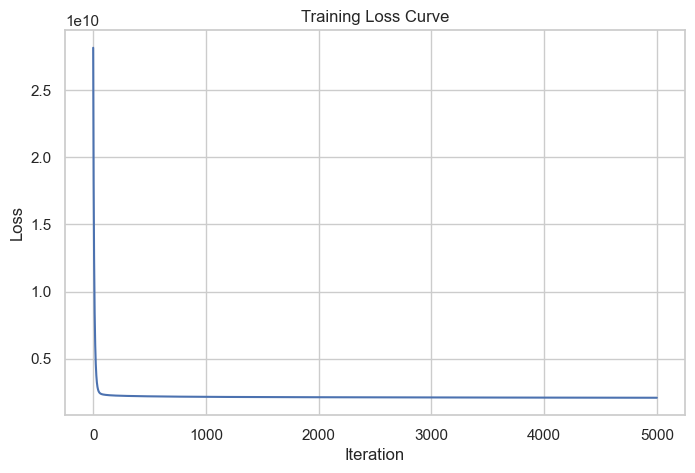

In [8]:
plt.figure(figsize=(8,5))
plt.plot(model.loss_history)
plt.title("Training Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)

plt.savefig("../reports/plots/02_training_loss_curve.png", dpi=300, bbox_inches="tight")
plt.show()

The loss curve demonstrates a rapid decrease followed by early stabilization, indicating that gradient descent converges efficiently without oscillation or divergence. The hyperparameters used here were selected through the hyperparameter tuning module in the source code, which is why the number of iterations remains high even though convergence occurs early. The iteration count is kept unchanged for consistency across experiments and reproducibility.

### 🎯 Predicted vs. Actual Values (Custom GD Model) <a id="error-diagnostics"></a>

Visualize the alignment between true housing prices and the model’s predictions. This scatter plot provides a direct assessment of prediction quality and reveals systematic errors, underfitting patterns, or deviations from the ideal 1:1 relationship.

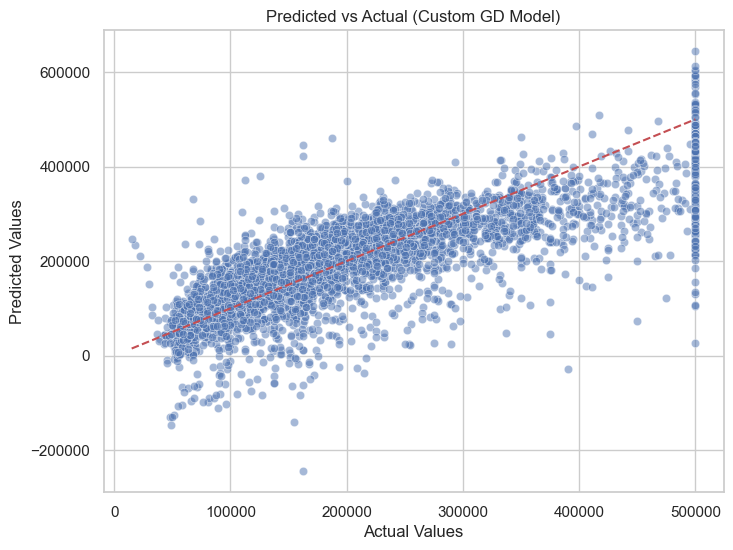

In [9]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_custom, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual (Custom GD Model)")

plt.savefig("../reports/plots/02_predicted_actual_custom.png", dpi=300, bbox_inches="tight")
plt.show()

The scatter plot shows noticeable spread around the ideal reference line, indicating prediction errors across a wide range of housing values. The model captures general trends but struggles with precise estimation, especially for higher-priced homes. This pattern is consistent with the earlier evaluation metrics and reflects the limitations of a linear optimization approach on a dataset with complex structure.

### 🌐 Residual Distribution (Custom Model)

Plot the distribution of residuals to examine the model’s prediction errors. A centered, symmetric residual distribution indicates a well-behaved linear model, while skewness or heavy tails may reveal systematic underestimation or overestimation patterns.

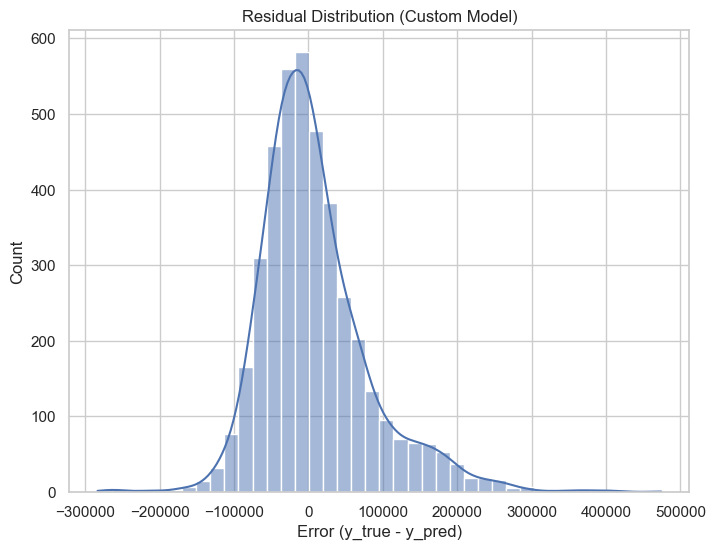

In [10]:
residuals = y_test.to_numpy() - y_pred_custom

plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=40, kde=True)
plt.title("Residual Distribution (Custom Model)")
plt.xlabel("Error (y_true - y_pred)")

plt.savefig("../reports/plots/02_residual_distribution_custom.png", dpi=300, bbox_inches="tight")
plt.show()

The residuals are centered near zero but exhibit noticeable spread and mild right-tail skewness. This suggests the model tends to underestimate higher housing prices and does not fully capture the nonlinear structure of the target variable. The wide dispersion aligns with the earlier MAE and RMSE values, confirming substantial variability in prediction errors.

### 💾 Export Evaluation Metrics <a id="metric-export"></a>

Store the custom model’s evaluation metrics in a JSON file for later comparison with additional models. Saving the results in a structured format ensures reproducibility and allows automated retrieval during reporting or analysis.

In [11]:
import json
import os

os.makedirs("../reports/metrics", exist_ok=True)

metrics = {
    "mae": metrics_custom["mae"],
    "rmse": metrics_custom["rmse"],
    "r2": metrics_custom["r2"]
}

with open("../reports/metrics/02_custom_model.json", "w") as f:
    json.dump(metrics, f, indent=4)

---
## 📝 Summary - Custom Gradient Descent Model Evaluation

This notebook evaluated the performance of the custom Gradient Descent regression model trained on engineered and standardized features. The optimization process converged smoothly, as reflected in the rapidly stabilizing loss curve.  

The quantitative evaluation showed:

- **MAE:** ~53,437  
- **RMSE:** ~74,661  
- **R²:** ~0.575  

These results indicate moderate predictive accuracy. The relatively high error values and the R² score below 0.6 suggest that the model explains only part of the variance in housing prices. Diagnostic plots further revealed wide error dispersion and consistent underestimation of higher-priced homes, highlighting the limitations of a linear model when applied to a dataset with complex spatial and nonlinear patterns.

**Next Step:** Proceed to `03_sklearn_baseline.ipynb` to evaluate a baseline Linear Regression model using scikit-learn. This provides a reference benchmark for comparing the performance of the custom implementation against a standardized library model.